In [1]:
from unity_dataset import UnityDataset

import os

import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [2]:
def get_device():
    # if torch.cuda.is_available():
    #     device = "cuda:0"
    # else:
    #     device = "cpu"
    # return device

    return "cuda:0"

In [3]:

NUM_EPOCHS = 5
LEARNING_RATE = 1e-3
BATCH_SIZE = 128

IMG_SIZE = (480, 360)
PATCH_SIZE = (72, 96)
LIGHT_DATA_SIZE = 12

TRAIN_SET_PERCENT = 0.8
TEST_SET_LENGTH = 128

INPUT_IMAGE_DIR = "/media/blooker/Storage/gold-project-2021-images/480p/"

OUTPUT_IMAGE_DIR = "data/Data/Img"

transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
dataset = UnityDataset(root_dir=INPUT_IMAGE_DIR,
                       lit_folder='lit',
                       unlit_folder='unlit',
                       depth_folder='depth',
                       csv_file='pos_data.csv',
                       img_size=IMG_SIZE,
                       patch_size=PATCH_SIZE,
                       light_data_size=LIGHT_DATA_SIZE,
                       transform=transform)

In [5]:
dataset_len = len(dataset)

train_set_length = int((dataset_len - TEST_SET_LENGTH) * TRAIN_SET_PERCENT)
val_set_length = (dataset_len - TEST_SET_LENGTH) - train_set_length

lengths = [train_set_length, val_set_length, TEST_SET_LENGTH]

In [6]:
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, lengths)

train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False)

torch.Size([1152])
torch.Size([12])
0.4444444444444444


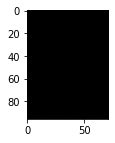

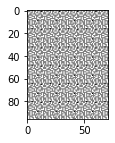

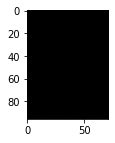

In [7]:
i = 40

plt.figure(figsize=(10,2))

x_img, x_dep, x_patch, x_pos, x_light, y = test_set[i]

print(x_pos.shape)
print(x_light.shape)
print(x_patch)

img = x_img.permute(1,2,0)
plt.imshow(img)

plt.figure(figsize=(10,2))

img = x_dep.permute(1,2,0)
plt.imshow(img, cmap="gray")

plt.figure(figsize=(10,2))

img = y.permute(1,2,0)
plt.imshow(img)

In [8]:
def make_dir():
    if not os.path.exists(OUTPUT_IMAGE_DIR):
        os.makedirs(OUTPUT_IMAGE_DIR)

def save_decoded_image(img, epoch, phase):
    img = img.view(img.size(0), 3, PATCH_SIZE[1], PATCH_SIZE[0])
    path = ("./" + OUTPUT_IMAGE_DIR + "/linear_ae_image{}_{}.png").format(phase, epoch)
    save_image(img, path)

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # patch encoder
        self.enc_patch1 = nn.Linear(1, 15)
        self.enc_patch2 = nn.Linear(15, 60)
        self.enc_patch3 = nn.Linear(60, 108)

        # pos encoder
        self.enc_pos1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, stride=3)
        self.enc_pos2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)

        # light encoder
        self.enc_light1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, stride=3)
        self.enc_light2 = nn.Linear(32, 60)
        self.enc_light3 = nn.Linear(60, 108)

        # pos_patch_light encoder
        self.enc_pos_patch_light1 = nn.Conv2d(in_channels=34, out_channels=34, kernel_size=1)

        # pos_patch transpose
        self.pos_patch_light_transpose1 = nn.ConvTranspose2d(in_channels=34, out_channels=26, kernel_size=2, stride=2)
        self.pos_patch_light_transpose2 = nn.ConvTranspose2d(in_channels=26, out_channels=20, kernel_size=2, stride=2)
        self.pos_patch_light_transpose3 = nn.ConvTranspose2d(in_channels=20, out_channels=16, kernel_size=2, stride=2)

        # lit encoder
        self.enc_lit1 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=1)
        self.enc_lit2 = nn.Conv2d(in_channels=20, out_channels=28, kernel_size=3, padding=1)
        self.enc_lit3 = nn.Conv2d(in_channels=28, out_channels=36, kernel_size=3, padding=1)

        # decoder
        self.dec1 = nn.Conv2d(in_channels=36, out_channels=54, kernel_size=3, padding=1)
        self.dec2 = nn.Conv2d(in_channels=54, out_channels=72, kernel_size=3, padding=1)
        self.dec3 = nn.Conv2d(in_channels=72, out_channels=144, kernel_size=3, padding=1)

        self.dec4 = nn.Conv2d(in_channels=144, out_channels=3, kernel_size=3, padding=1)

    def forward(self, x_unlit, x_dep, x_patch, x_pos, x_light):
        # enc_patch
        x_patch = F.relu(self.enc_patch1(x_patch))  # (b, 12)
        x_patch = F.relu(self.enc_patch2(x_patch))  # (b, 60)
        x_patch = F.relu(self.enc_patch3(x_patch))  # (b, 108)
        x_patch = x_patch.reshape(-1, 1, 12, 9)  # (b, 1, 12, 9)

        # enc_pos
        x_pos.unsqueeze_(dim=1)  # (b, 1, 1152)
        x_pos = F.relu(self.enc_pos1(x_pos))  # (b, 8, 384)

        x_pos = F.max_pool1d(x_pos, kernel_size=2, stride=2)  # (b, 8, 192)

        x_pos = F.relu(self.enc_pos2(x_pos))  # (b, 16, 192)
        x_pos = x_pos.reshape(-1, 32, 96)  # (b, 32, 96)
        x_pos = F.pad(x_pos, pad=(0, 12, 0, 0, 0, 0))  # (b, 32, 108)
        x_pos = x_pos.reshape(-1, 32, 12, 9)  # (b, 32, 12, 9)

        # enc_light
        x_light.unsqueeze_(dim=1)  # (b, 1, 12)
        x_light = F.relu(self.enc_light1(x_light))  # (b, 8, 4)
        x_light = x_light.reshape(-1, 32)  # (b, 32)

        x_light = F.relu(self.enc_light2(x_light))  # (b, 60)
        x_light = F.relu(self.enc_light3(x_light))  # (b, 108)
        x_light = x_light.reshape(-1, 1, 12, 9)  # (b, 1, 12, 9)

        # Concatenate x_patch, x_pos and x_light together, then encode
        x_patch_pos_light = torch.cat((x_patch, x_pos, x_light), dim=1)  # (b, 34, 12, 9)
        x_patch_pos_light = F.relu(self.enc_pos_patch_light1(x_patch_pos_light))  # (b, 34, 12, 9)

        # Upscale x_patch_pos to sample image resolution
        x_patch_pos_light = F.relu(self.pos_patch_light_transpose1(x_patch_pos_light))  # (b, 26, 24, 18)
        x_patch_pos_light = F.relu(self.pos_patch_light_transpose2(x_patch_pos_light))  # (b, 20, 48, 36)
        x_patch_pos_light = F.relu(self.pos_patch_light_transpose3(x_patch_pos_light))  # (b, 16, 96, 72)

        # Concatenate x_patch_pos, x_unlit and x_dep
        x_lit = torch.cat((x_patch_pos_light, x_unlit, x_dep), 1)  # (b, 20, 96, 72)

        # lit encoder
        x_lit = F.relu(self.enc_lit1(x_lit))  # (b, 20, 96, 72)
        x_lit = F.relu(self.enc_lit2(x_lit))  # (b, 28, 96, 72)
        x_lit = F.relu(self.enc_lit3(x_lit))  # (b, 36, 96, 72)

        # decoder
        x_lit = F.relu(self.dec1(x_lit))  # (b, 54, 96, 72)
        x_lit = F.relu(self.dec2(x_lit))  # (b, 72, 96, 72)
        x_lit = F.relu(self.dec3(x_lit))  # (b, 144, 96, 72)

        x_lit = torch.sigmoid(self.dec4(x_lit))  # (b, 3, 96, 72)

        return x_lit


net = Autoencoder()
print(net)

Autoencoder(
  (enc_patch1): Linear(in_features=1, out_features=15, bias=True)
  (enc_patch2): Linear(in_features=15, out_features=60, bias=True)
  (enc_patch3): Linear(in_features=60, out_features=108, bias=True)
  (enc_pos1): Conv1d(1, 8, kernel_size=(3,), stride=(3,))
  (enc_pos2): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (enc_light1): Conv1d(1, 8, kernel_size=(3,), stride=(3,))
  (enc_light2): Linear(in_features=32, out_features=60, bias=True)
  (enc_light3): Linear(in_features=60, out_features=108, bias=True)
  (enc_pos_patch_light1): Conv2d(34, 34, kernel_size=(1, 1), stride=(1, 1))
  (pos_patch_light_transpose1): ConvTranspose2d(34, 26, kernel_size=(2, 2), stride=(2, 2))
  (pos_patch_light_transpose2): ConvTranspose2d(26, 20, kernel_size=(2, 2), stride=(2, 2))
  (pos_patch_light_transpose3): ConvTranspose2d(20, 16, kernel_size=(2, 2), stride=(2, 2))
  (enc_lit1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (enc_lit2): Conv2d(20, 28, kernel_size=(3, 3)

In [10]:
criterion = nn.MSELoss()
optimizer = optim.RMSprop(net.parameters(), lr=LEARNING_RATE)

In [11]:
def train(net, trainloader, validloader, NUM_EPOCHS):
    train_loss = []
    valid_loss = []

    nets = {"train": net}

    device = get_device()
    for epoch in range(NUM_EPOCHS):
        start_time = time.perf_counter()
        running_loss = 0.0

        for phase in ["train", "val"]:

            training = phase == "train"

            net.train(training)
            loader = None
            if training:
                loader = trainloader
            else:
                loader = validloader

            for data in loader:
                x, x_dep, x_patch, x_pos, x_light, y = data

                x = x.to(device, dtype=torch.float)
                x_dep = x_dep.to(device, dtype=torch.float)
                x_patch = x_patch.to(device, dtype=torch.float).unsqueeze(1)
                x_pos = x_pos.to(device, dtype=torch.float)
                x_light = x_light.to(device, dtype=torch.float)
                y = y.to(device, dtype=torch.float)

                optimizer.zero_grad()
                outputs = net(x, x_dep, x_patch, x_pos, x_light)
                loss = criterion(outputs, y)

                del x, x_dep, x_patch, x_pos, x_light, y

                if training:
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()

            loss = running_loss / len(loader)

            if training:
                train_loss.append(loss)
            else:
                valid_loss.append(loss)

            print("Epoch {} of {}, {} loss: {:.6f}, Time: {:.4f}".format(
                epoch+1, NUM_EPOCHS, phase, loss, time.perf_counter()-start_time
            ))

            save_decoded_image(outputs.cpu().data, epoch, phase)

        print()

    return train_loss, valid_loss

In [12]:

def test_image_reconstruction(net, testloader):
    device = get_device()
    for batch in testloader:
        x, x_dep, x_patch, x_pos, x_light, _ = batch
        x = x.to(device, dtype=torch.float)
        x_dep = x_dep.to(device, dtype=torch.float)
        x_patch = x_patch.to(device, dtype=torch.float).unsqueeze(1)
        x_pos = x_pos.to(device, dtype=torch.float)
        x_light = x_light.to(device, dtype=torch.float)
        # img = img.view(img.size(0), -1)
        outputs = net(x, x_dep, x_patch, x_pos, x_light)
        outputs = outputs.view(outputs.size(0), 3, PATCH_SIZE[1], PATCH_SIZE[0]).cpu().data
        save_image(outputs, "./" + OUTPUT_IMAGE_DIR + '/reconstruction.png')
        break

In [13]:
device = get_device()
print(device)
net.to(device)

cuda:0


Autoencoder(
  (enc_patch1): Linear(in_features=1, out_features=15, bias=True)
  (enc_patch2): Linear(in_features=15, out_features=60, bias=True)
  (enc_patch3): Linear(in_features=60, out_features=108, bias=True)
  (enc_pos1): Conv1d(1, 8, kernel_size=(3,), stride=(3,))
  (enc_pos2): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (enc_light1): Conv1d(1, 8, kernel_size=(3,), stride=(3,))
  (enc_light2): Linear(in_features=32, out_features=60, bias=True)
  (enc_light3): Linear(in_features=60, out_features=108, bias=True)
  (enc_pos_patch_light1): Conv2d(34, 34, kernel_size=(1, 1), stride=(1, 1))
  (pos_patch_light_transpose1): ConvTranspose2d(34, 26, kernel_size=(2, 2), stride=(2, 2))
  (pos_patch_light_transpose2): ConvTranspose2d(26, 20, kernel_size=(2, 2), stride=(2, 2))
  (pos_patch_light_transpose3): ConvTranspose2d(20, 16, kernel_size=(2, 2), stride=(2, 2))
  (enc_lit1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (enc_lit2): Conv2d(20, 28, kernel_size=(3, 3)

In [14]:
make_dir()

train_loss, valid_loss = train(net, train_loader, valid_loader, NUM_EPOCHS)

Epoch 1 of 5, train loss: 0.014026, Time: 19070.3666
Epoch 1 of 5, val loss: 0.068757, Time: 22995.8311

Epoch 2 of 5, train loss: 0.011128, Time: 18848.3522
Epoch 2 of 5, val loss: 0.057527, Time: 22713.7037

Epoch 3 of 5, train loss: 0.010461, Time: 18708.2705
Epoch 3 of 5, val loss: 0.052178, Time: 22573.6267

Epoch 4 of 5, train loss: 0.010093, Time: 18743.6635
Epoch 4 of 5, val loss: 0.050426, Time: 22626.7769

Epoch 5 of 5, train loss: 0.009862, Time: 18827.2818
Epoch 5 of 5, val loss: 0.049595, Time: 22738.6862



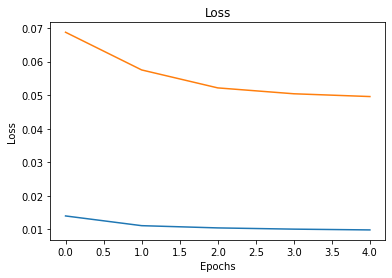

In [15]:
plt.figure()
plt.plot(train_loss)
plt.plot(valid_loss)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("./" + OUTPUT_IMAGE_DIR + "/deep_ae_loss.png")

In [16]:
net.to(device)
test_image_reconstruction(net, test_loader)

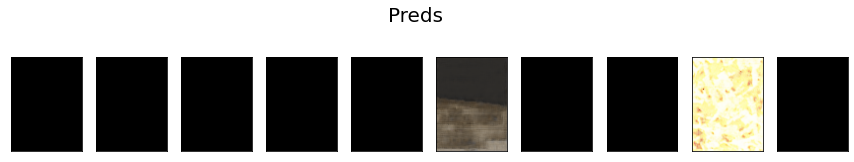

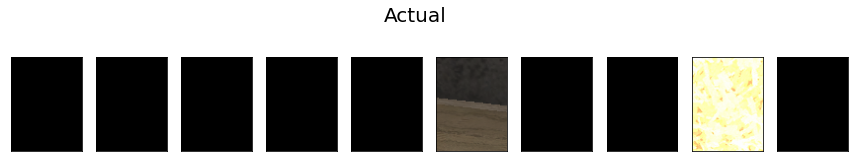

In [17]:
x_images = np.array([])
y_images = np.array([])

for batch in test_loader:
    x, x_dep, x_patch, x_pos, x_light, y = batch
    x = x.to(device, dtype=torch.float)
    x_dep = x_dep.to(device, dtype=torch.float)
    x_patch = x_patch.to(device, dtype=torch.float).unsqueeze(1)
    x_pos = x_pos.to(device, dtype=torch.float)
    x_light = x_light.to(device, dtype=torch.float)

    # img = img.view(img.size(0), -1)
    outputs = net(x, x_dep, x_patch, x_pos, x_light)

    outputs = outputs.view(outputs.size(0), 3, PATCH_SIZE[1], PATCH_SIZE[0]).cpu().data

    y_images = y
    x_images = outputs

    save_image(x, "./" + OUTPUT_IMAGE_DIR + '/unlit.png')
    save_image(outputs, "./" + OUTPUT_IMAGE_DIR + '/reconstruction.png')
    save_image(y, "./" + OUTPUT_IMAGE_DIR + '/actual.png')
    break

def show_data(X, n=10, title=""):
    plt.figure(figsize=(15,5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = X[i].permute(1,2,0)
        plt.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.suptitle(title, fontsize=20)

show_data(x_images, title="Preds")
show_data(y_images, title="Actual")

In [18]:
# Input to the model
x = torch.randn(1, 3, PATCH_SIZE[1], PATCH_SIZE[0])
x_dep = torch.randn(1, 1, PATCH_SIZE[1], PATCH_SIZE[0])
x_patch = torch.randn(1, 1)
x_pos = torch.randn(1, 1164 - LIGHT_DATA_SIZE)
x_light = torch.randn(1, LIGHT_DATA_SIZE)

net.cpu()

# Export the model
torch.onnx.export(net,                                  # model being run
                  (x, x_dep, x_patch, x_pos, x_light),  # model input (or a tuple for multiple inputs)
                  "./data/Data/model.onnx",             # where to save the model (can be a file or file-like object)
                  export_params=True,                   # store the trained parameter weights inside the model file
                  opset_version=9,                      # the ONNX version to export the model to
                  do_constant_folding=True,             # whether to execute constant folding for optimization
                  input_names = ['enc1'],               # the model's input names
                  output_names = ['dec3']               # the model's output names
                  )